**Convolutional Neural Network for Supervised Learning**
<p>CNN for supervised learning of glacier vs forest images.
<br>Using torch.
</p>
<p>Network Accuracy:
<br>Accuracy of the network: 95.13145082765335 %
<br>Accuracy of forest: 92.19409282700423 %
<br>Accuracy of glacier: 97.64918625678119 %
</p>

In [2]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


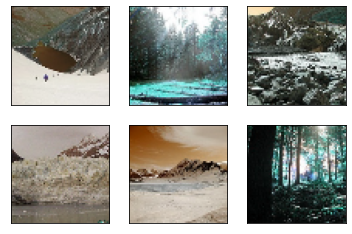

In [38]:
# Read Database 
def read_db(path):
    with open(path, 'rb') as handle:
      images  = pickle.load(handle)
      classes = pickle.load(handle)
    return images, classes

# Read Train set
images_train, classes_train = read_db('/content/drive/My Drive/WLD_AI/train/forest_glacier_train.pkl')
# Read Test Set
images_test, classes_test = read_db('/content/drive/My Drive/WLD_AI/test/forest_glacier_test.pkl')
# Show some of the images
for ii in range(6):
    plt.subplot(2, 3, ii + 1)
    rand_im = np.random.randint(0, len(images_test))
    im = images_test[rand_im]
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])


In [41]:
# Configurations
num_epochs = 5
batch_size = 5
learning_rate = 0.001

for i in range(len(images_train)):
  images_train[i] = images_train[i].reshape(3,64, 64)

# Convert the pickle object to a PyTorch tensor
classes_names = ('forest', 'glacier')

tensor_images = torch.tensor(np.array(images_train), dtype=torch.float32)
train_loader_images = torch.utils.data.DataLoader(tensor_images, batch_size=batch_size, shuffle=False)
tensor_classes = torch.tensor(np.array(classes_train), dtype=torch.long)
train_loader_classes = torch.utils.data.DataLoader(tensor_classes, batch_size=batch_size, shuffle=False)

combined = list(zip(train_loader_images, train_loader_classes))
random.shuffle(combined)
train_loader_images, train_loader_classes = zip(*combined)

# The model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=4)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=4)
        
        self.max_pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(in_features=16*13*13, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.output = nn.Linear(in_features=84, out_features=2)
    
    def forward(self, x):
        # Pass the input through the convolutional layers, activation functions, and max pooling layer
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*13*13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

# Start learning     
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader_images)

for epoch in range(num_epochs):
  for i, (images, classes) in enumerate(zip(train_loader_images, train_loader_classes)):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, classes)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 467 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
  

Epoch [1/5], Step [467/935], Loss: 0.1037
Epoch [1/5], Step [934/935], Loss: 0.0120
Epoch [2/5], Step [467/935], Loss: 0.0645
Epoch [2/5], Step [934/935], Loss: 0.0025
Epoch [3/5], Step [467/935], Loss: 0.1025
Epoch [3/5], Step [934/935], Loss: 0.0007
Epoch [4/5], Step [467/935], Loss: 0.1413
Epoch [4/5], Step [934/935], Loss: 0.0003
Epoch [5/5], Step [467/935], Loss: 0.0764
Epoch [5/5], Step [934/935], Loss: 0.0004


In [42]:
# Test Accuracy
for i in range(len(images_test)):
  images_test[i] = images_test[i].reshape(3,64, 64)

tensor_images_test = torch.tensor(np.array(images_test), dtype=torch.float32)
test_loader_images = torch.utils.data.DataLoader(tensor_images_test, batch_size=1, shuffle=False)
tensor_classes_test = torch.tensor(np.array(classes_test), dtype=torch.long)
test_loader_classes = torch.utils.data.DataLoader(tensor_classes_test, batch_size=1, shuffle=False)


with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]

    for index, (images, classes) in enumerate(zip(test_loader_images, test_loader_classes)):
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += classes.size(0)
        n_correct += (predicted == classes).sum().item()
      
        for i in range(len(classes)):
          label = classes[i]
          pred = predicted[i]
          if (label == pred):
            n_class_correct[label] += 1
          n_class_samples[label] += 1       
          
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes_names[i]}: {acc} %')  



Accuracy of the network: 95.13145082765335 %
Accuracy of forest: 92.19409282700423 %
Accuracy of glacier: 97.64918625678119 %


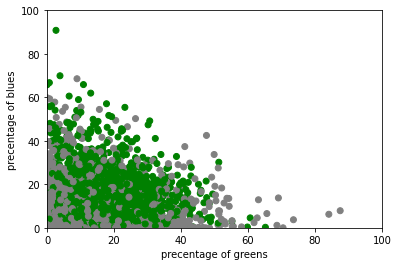

In [50]:
from matplotlib.ticker import IndexFormatter

combined = list(zip(images_train, classes_train))
random.shuffle(combined)
images_train, classes_train = zip(*combined)


# The Impact of green and blue colors in pictures on its classification
x_green = np.array([])
y_blues = np.array([])
color = np.array([])

classColor= ['green', 'gray']
pixels_in_one_picture =  64*64
for i, (image, classification) in enumerate(zip(np.array(images_train), np.array(classes_train))):
  blue_pixels  = 0 # (x, x, y) y > x
  green_pixels  = 0 # (x, y, x) y > x
  rgb = np.array([0,0,0], dtype='int')
  for x in range(image.shape[1]):
    for y in range(image.shape[2]):
      for c in range(image.shape[0]):
        rgb[c] = image[c][x][y]
      if (rgb[2] > rgb[1] + rgb[0]):
        blue_pixels = blue_pixels + 1
      if (rgb[1] > rgb[0] + rgb[2]):
        green_pixels = green_pixels + 1
  x_green = np.append(x_green, 100*green_pixels/pixels_in_one_picture)
  y_blues = np.append(y_blues, 100*blue_pixels/pixels_in_one_picture)
  color = np.append(color, classColor[classification]) 

plt.xlabel('precentage of greens')
plt.ylabel('precentage of blues')
plt.title("The Impact of green and blue colors in pictures on its classification")
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.scatter(x_green, y_blues, color=color)
plt.show() 